# imports..

In [1]:
import json
import yaml
import numpy as np
import pandas as pd
from copy import deepcopy
import warnings
warnings.filterwarnings(action='once')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
vault = 'DynLst'

In [4]:
strategies: dict[str, list[dict[str, str]]] = dict()
strategies['DynLst'] = pd.Series(name='DynLst', data={
  "42c02674-f7a2-4cb0-be3d-ade268838770": "balancer-v2_RETH-WETH",
  "4cc5df76-f81d-49fe-9e1e-4caa6a8dad0b": "balancer-v2_WSTETH-WETH",
  "5ce23e7e-3800-4c9c-ad30-6db3db0515a1": "convex-finance_ETH-STETH",
  "747c1d2a-c668-4682-b9f9-296708a3dd90": "lido_STETH",
  "77020688-e1f9-443c-9388-e51ace15cc32": "frax-ether_SFRXETH",
  "c9873dab-0979-478c-b48c-3c3a0c935449": "convex-finance_STETH-FRXETH",
  "d4b3c522-6127-4b89-bedf-83641cdcd2eb": "rocket-pool_RETH",
  "e378a7c2-6285-4993-9397-87ac9c8adc15": "convex-finance_ETH-STETH",
  "e6435aae-cbe9-4d26-ab2c-a4d533db9972": "aave-v3_WSTETH",
  "f1a22245-a1f1-4389-8ff2-dde4914b272d": "aave-v3_RETH",
  "fc7701fc-e290-4606-a8be-9e4ba6c5f91a": "convex-finance_ETH-RETH"
}).reset_index()

In [5]:
strategies: dict[str, list[dict[str, str]]] = dict()
strategies['DynLst'] = pd.Series(name='DynLst', data={
 "42c02674-f7a2-4cb0-be3d-ade268838770": "balancer-v2_RETH-WETH",
 "4cc5df76-f81d-49fe-9e1e-4caa6a8dad0b": "balancer-v2_WSTETH-WETH",
 "6d342d6a-9796-443e-8152-b94e8b6021fc": "convex-finance_ETH-FRXETH",
 "747c1d2a-c668-4682-b9f9-296708a3dd90": "lido_STETH",
 "77020688-e1f9-443c-9388-e51ace15cc32": "frax-ether_SFRXETH",
 "98463e86-e32c-4998-830c-ccd47dbb3041": "aura_WSTETH-WETH",
 "a4b5b995-99e7-4b8f-916d-8940b5627d70": "aura_RETH-WETH",
 "c9873dab-0979-478c-b48c-3c3a0c935449": "convex-finance_STETH-FRXETH",
 "ce70e358-6668-498c-9afa-651f770eac27": "aura_WSTETH-SFRXETH-RETH",
 "d4b3c522-6127-4b89-bedf-83641cdcd2eb": "rocket-pool_RETH",
 "e378a7c2-6285-4993-9397-87ac9c8adc15": "convex-finance_ETH-STETH",
 "e6435aae-cbe9-4d26-ab2c-a4d533db9972": "aave-v3_WSTETH",
 "f1a22245-a1f1-4389-8ff2-dde4914b272d": "aave-v3_RETH",
 "fc7701fc-e290-4606-a8be-9e4ba6c5f91a": "convex-finance_ETH-RETH"
}).reset_index()
strategies['DynYieldE'] = pd.Series(name='DynYieldE', data={
  "1343a280-7812-4bc3-8f98-d1c37e11d271": "morpho-aave_USDT",
  "25171c4c-1877-449a-9f88-45a9f153ee31": "curve-dex_DAI-USDC-USDT",
  "30339b96-be67-45e5-87cb-adcd91049803": "convex-finance_ADAI-AUSDC-AUSDT",
  "325ad2d6-70b1-48d7-a557-c2c99a036f87": "morpho-aave_USDC",
  "3665ee7e-6c5d-49d9-abb7-c47ab5d9d4ac": "aave-v3_DAI",
  "3f6aa14f-eb0c-4738-bf74-8bc666f7d2b1": "curve-dex_FRAX-USDC",
  "405d8dad-5c99-4c91-90d3-82813ade1ff1": "aave-v2_DAI",
  "57647093-2868-4e65-97ab-9cae8ec74e7d": "compound_USDT",
  "60d657c9-5f63-4771-a85b-2cf8d507ec00": "aave-v2_USDT",
  "7394f1bc-840a-4ff0-9e87-5e0ef932943a": "convex-finance_DAI-USDC-USDT",
  "802d35a2-5bae-456f-a2a9-4e1b48e0dec5": "uniswap-v3_DAI-USDT",
  "8ec9e3e2-1eb5-4c47-82de-edcc825ca4cc": "curve-dex_CDAI-CUSDC",
  "a349fea4-d780-4e16-973e-70ca9b606db2": "aave-v2_USDC",
  "a86ee795-54d9-4812-9148-b312967cefe5": "uniswap-v2_DAI-USDC",
  "aa70268e-4b52-42bf-a116-608b370f9501": "aave-v3_USDC",
  "b8bcdf8e-96ed-40ca-a7aa-aa048b9874e5": "morpho-aave_DAI",
  "bd072651-d99c-4154-aeae-51f12109c054": "convex-finance_FRAX-USDC",
  "c8a24fee-ec00-4f38-86c0-9f6daebc4225": "makerdao_DAI",
  "cc110152-36c2-4e10-9c12-c5b4eb662143": "compound_DAI",
  "cefa9bb8-c230-459a-a855-3b94e96acd8c": "compound_USDC",
  "d6e3dd14-0495-4aec-b226-ae98215dcd38": "uniswap-v3_DAI-FRAX",
  "e2c09021-0aa8-42b6-a596-5422c2e35399": "uniswap-v2_USDC-USDT",
  "e3f861c0-c2b9-4b50-b799-a036a3f11da1": "curve-dex_ADAI-AUSDC-AUSDT",
  "f981a304-bb6c-45b8-b0c5-fd2f515ad23a": "aave-v3_USDT"
}).reset_index()
strategies['DynYieldB'] = pd.Series(name='DynYieldB', data={
  "0e66dcfe-c01e-4c3b-81f9-99e0a6ab0903": "pancakeswap-amm-v3_USDC-BUSD",
  "282baaa9-11ef-4e72-8ade-efe0c43c07cc": "pancakeswap-amm-v3_USDT-USDC",
  "89eba1e5-1b1b-47b6-958b-38138a04c244": "venus_USDC",
  "9f0f4cbd-5a26-4eb8-b720-3691b42b0e56": "pancakeswap-amm-v3_USDT-BUSD",
  "9f3a6015-5045-4471-ba65-ad3dc7c38269": "venus_USDT",
  "b2e9d5fe-19ca-456b-8cd5-c296d635136f": "pancakeswap-amm-v3_USDT-USDC"
}).reset_index()

# load data

In [6]:
metadata = pd.read_csv(f"C:/Users/david/singularity/midfreq/scrappers/defillama_history/data/{vault}_pool_metadata.csv")
with open(f"C:/Users/david/singularity/midfreq/config/{vault.lower()}.yaml") as file:
    parameters= yaml.safe_load(file)
pool_map = metadata.loc[metadata['pool'].isin(parameters['input_data']['selected_instruments']),['pool','project','symbol']].set_index('pool').T.to_dict()
pool_map = {key: '{}_{}'.format(x['project'], x['symbol']) for key, x in pool_map.items()}
index_map = {f'weight_{i}': f'w_{value}' for i, value in enumerate(pool_map.values())}
index_map |= {f'yield_{i}': f'y_{value}' for i, value in enumerate(pool_map.values())} 
with open(f"C:/Users/david/singularity/midfreq/config/{vault.lower()}.yaml", 'r') as fp:
    parameters = yaml.safe_load(fp)

C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



### naive optimization - no swap_cost

In [7]:
parameter_grid = {"cap": 3,
                  "halflife": "1s",
                  "cost": 0.0001,
                  "gaz": False,
                  "assumed_holding_days": 9999,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [8]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

apy.mean()

8.037308175467214

### naive optimization - 10bps swap_cost

In [9]:
parameter_grid = {"cap": 3,
                  "halflife": "1s",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 9999,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [10]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/3_1s_0.001_False_9999_0.15_1.0__backtest.csv


-0.7924730211981309

### cost aware optimization (28d holding)

In [11]:
parameter_grid = {"cap": 3,
                  "halflife": "1s",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 28,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [12]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/3_1s_0.001_False_28_0.15_1.0__backtest.csv


5.388830243241003

# cost aware smoothed (10d) optimization (28d holding)

In [13]:
parameter_grid = {"cap": 3,
                  "halflife": "10d",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 28,
                  "base_buffer": 0.15,
                  "concentration_limit": 0.7}
filename = "C:/Users/david/singularity/midfreq/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])
backtest['weights'].columns = [strategies[vault][vault][int(col)] if col != 'total' else col for col in backtest['weights'].columns ]

In [14]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean(), max_apy.mean()

C:/Users/david/singularity/midfreq/logs/dynlst/3_10d_0.001_False_28_0.15_0.7__backtest.csv


(6.769482927130343, 9.054344910511361)

## zoom on optimal settings

In [15]:
weights = backtest['weights']
weights = weights.rename(columns={col: strategies[vault][vault][int(col)] if col != 'total' else col for col in backtest['weights'].columns})
weights.iplot(title='weights')

In [16]:
apy = backtest['apy']
apy = apy.rename(columns={col: strategies[vault][vault][int(col)] if col != 'total' else col for col in backtest['weights'].columns})
apy.iplot(title='apy')

In [17]:
tracking_error = (backtest['pred_apy'].rolling(28).mean().shift(-28)-backtest['apy'])
tracking_error = tracking_error.rename(columns={col: strategies[vault][vault][int(col)] if col != 'total' else col for col in backtest['weights'].columns})
tracking_error.iplot(title='tracking_error')

C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



# heatmaps

In [18]:
parameter_grid = {"cap": [3, 999],
                  "halflife": ["1s", "3d", "10d", "30d"],
                  "cost": [0.0001, 0.0005, 0.001, 0.005],
                  "gaz": [False],
                  "assumed_holding_days": [3, 8, 13, 18, 23, 28, 32, 9999],
                  "base_buffer": [0.15],
                  "concentration_limit": [0.4,
                                          0.7, 1.0]}

In [19]:
grid = pd.read_csv(f"C:/Users/david/singularity/midfreq/logs/{vault.lower()}/grid.csv", index_col=0)
grid['tx_cost'].iloc[0] = 0.001
grid = grid.rename(columns={'cost': 'swap_cost'})
all_index = {col: grid[col].unique() for col in grid.columns}
print(grid.columns)

grid['churn in d'] = grid.apply(lambda x: 2 * 365 * x['swap_cost']/x['tx_cost']/100, axis=1)

format_dict = {key: (lambda x: x) for key in grid.columns}
format_dict['perf'] = lambda x: f'{x:.1%}'
format_dict['tx_cost'] = lambda x : f'{x:.0f}'
format_dict['avg_entropy'] = lambda x: f'{x:.0%}'

def display_heatmap(metrics, ind, col, filtering):
    fig = plt.figure(figsize = (20,20)) # width x height
    
    # filter
    filtered_grid = grid[np.logical_and.reduce([
            grid[filter_c]==filter_v
        for filter_c, filter_v in filtering.items()])]
    
    # pivot and display
    for i, values in enumerate(metrics):
        for j, column in enumerate(col):
            df = filtered_grid.pivot_table(values=values, index=ind, columns=col)*100
            ax = fig.add_subplot(len(col), len(metrics), i+j+1)
            ax.set_title(f'{values} by {column}')
            sns.heatmap(data=df, ax=ax, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

C:\Users\david\singularity\midfreq\venv\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



Index(['cap', 'halflife', 'swap_cost', 'gaz', 'assumed_holding_days',
       'base_buffer', 'concentration_limit', 'perf', 'tx_cost', 'avg_entropy'],
      dtype='object')


## churn vs     activeness / predictor halflife -> halflife = 10d horizon = ~4w

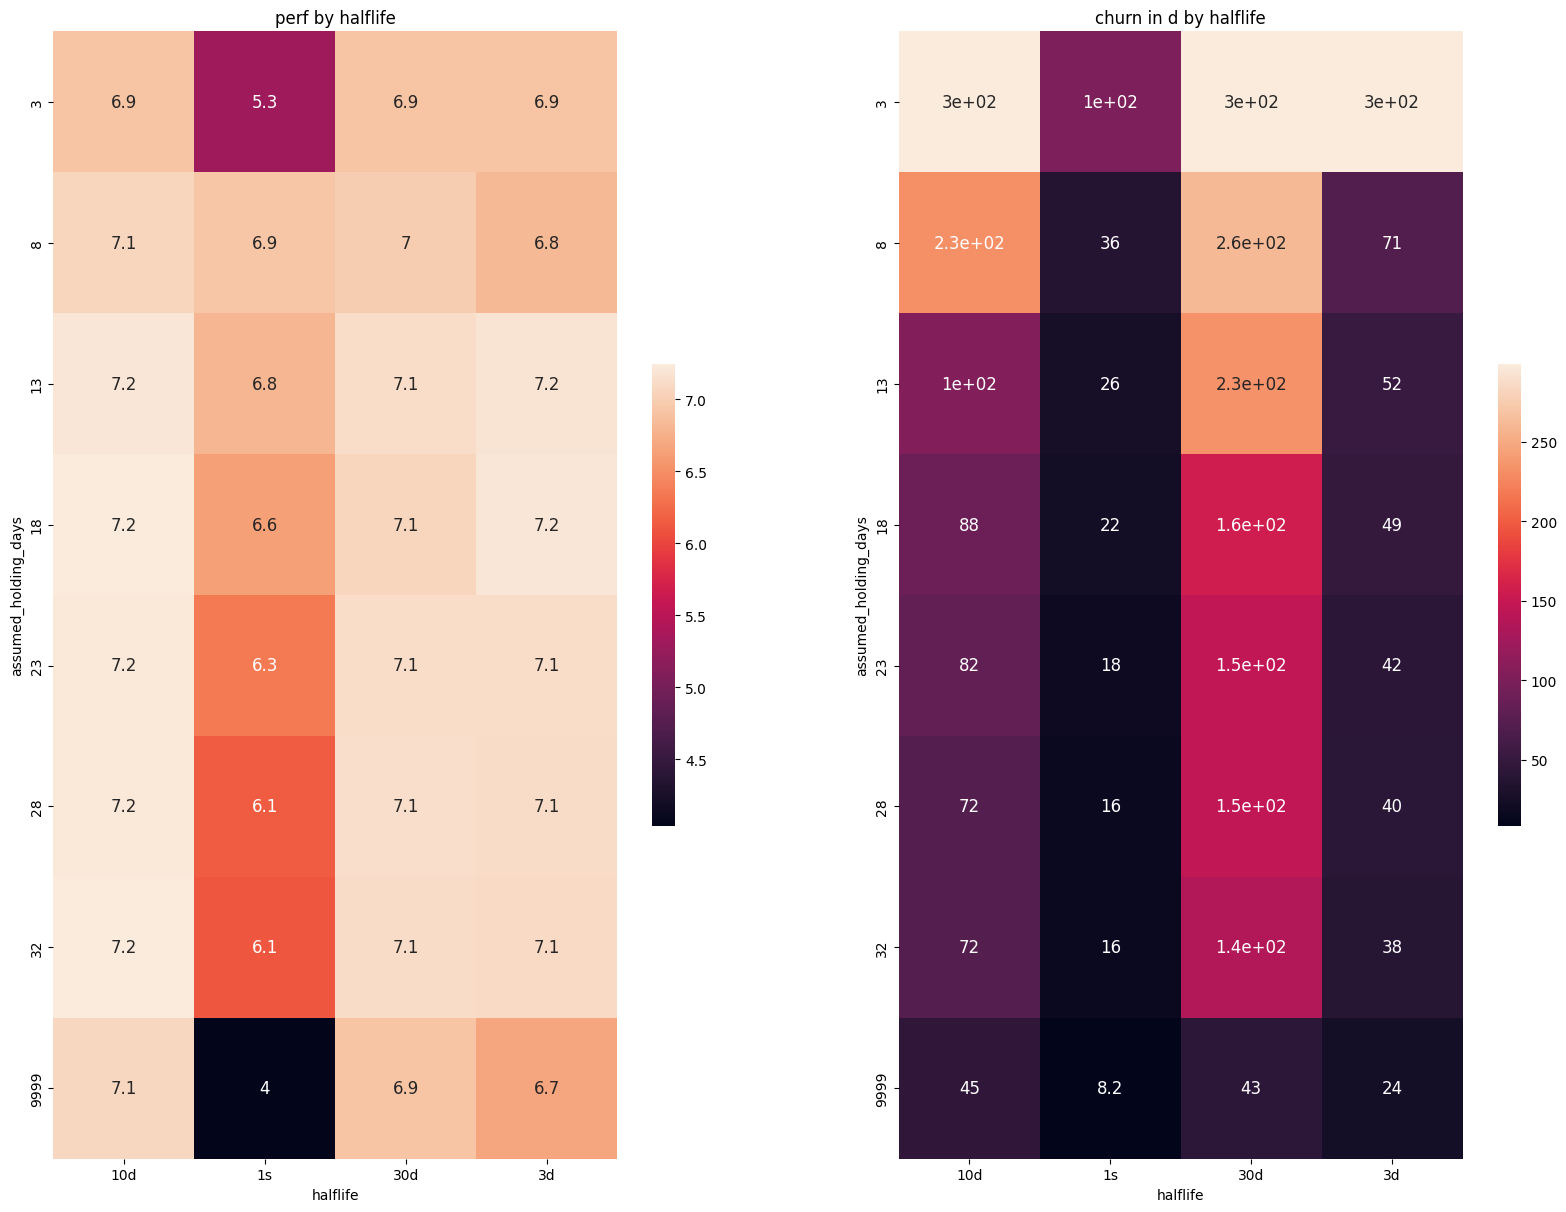

In [20]:
metrics = ['perf', 'churn in d']
ind = ['assumed_holding_days']
col = ['halflife']
filtering = {
    'cap': 3,
#    'halflife': "30d",
    'swap_cost': 5e-4,
    'gaz': False,
#    'assumed_holding_days': 32,
    'base_buffer': 0.15,
    'concentration_limit': 0.7,
}
display_heatmap(metrics, ind, col, filtering)

## entropy vs     concentration x activeness

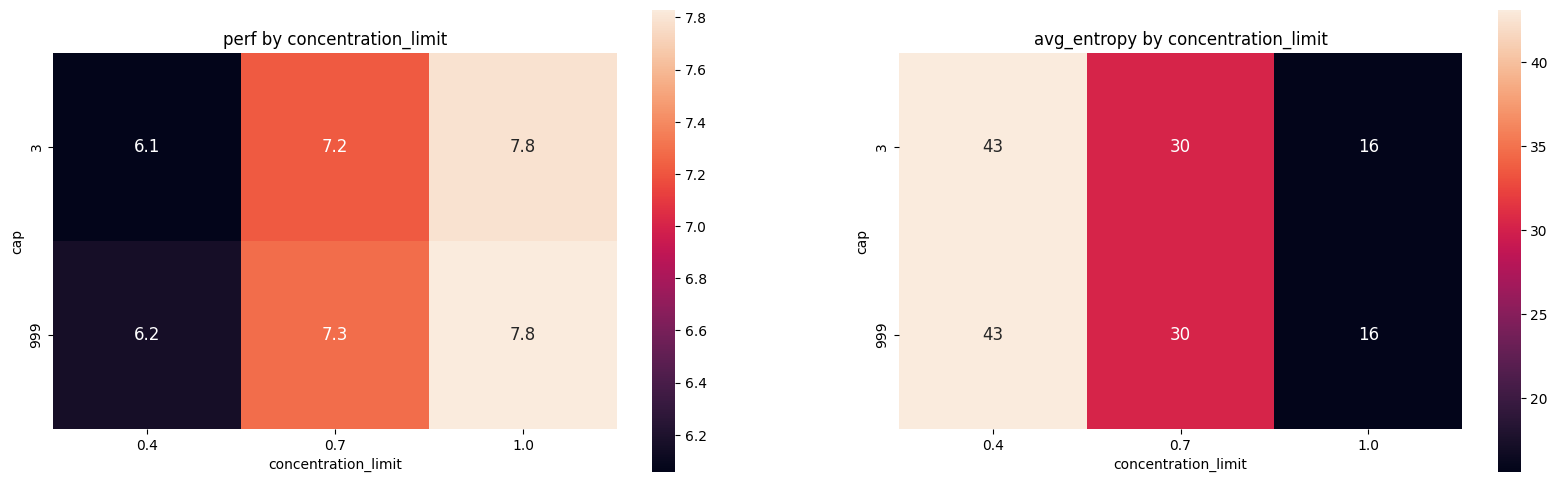

In [21]:
filtering = {
#    'cap': 0.2,
    'halflife': '10d',
    'swap_cost': 5e-4,
    'gaz': False,
    'assumed_holding_days': 28,
    'base_buffer': 0.15,
#    'concentration_limit': 0.4,
}
metrics = ['perf', 'avg_entropy']
ind = ['cap']
col = ['concentration_limit']
display_heatmap(metrics, ind, col, filtering)